 ## Imports and Setup

In [1]:
import os
import sys
import numpy as np
import torch
import random
from tqdm.notebook import tqdm
import wandb
import timm
from pathlib import Path


# Add the src directory to the sys.path
sys.path.append(os.path.abspath('..'))

# from secret_runway_detection.model import CombinedModel, SegmentationHead

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


 ## Configuration Parameters

In [2]:
DEBUG = True

# BUFFER_TYPE = 'cross'
RUN_PATH = 'esedx12/secret-runway-detection/w0o8x4a8'

# THRESHOLD = 0.5  # Adjust based on validation performance

In [3]:
# Load the W&B run
train_run = wandb.Api().run(RUN_PATH)
train_run.name

'helpful-paper-98'

 ## Load the Trained Model

In [4]:
from more_itertools import one

# Fetch the model artifact from the W&B run
artifacts = train_run.logged_artifacts()
model_artifacts = [a for a in artifacts if a.type == 'model']
artifact = one(model_artifacts)
state_dict_dir = artifact.download(root='../artifacts/')
state_dict_dir = Path(state_dict_dir)
state_dict_path = state_dict_dir / f'{train_run.name}.pth'
state_dict_path

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


PosixPath('../artifacts/helpful-paper-98.pth')

In [5]:
model_type = train_run.config['model_type']
print(f"Model type: {model_type}")

Model type: custom


In [6]:
# Now load the type backbone_config artifact the same way you loaded the model and put it in a temp directory
backbone_config_artifacts = [a for a in artifacts if a.type == 'backbone_config']
backbone_config_artifact = one(backbone_config_artifacts)
backbone_config_dir = backbone_config_artifact.download(root='../artifacts/')
backbone_config_dir = Path(backbone_config_dir)
backbone_config_path = backbone_config_dir / f'{train_run.name}.yaml'
backbone_config_path


wandb:   1 of 1 files downloaded.  


PosixPath('../artifacts/helpful-paper-98.yaml')

In [7]:
list(artifacts)

for artifact in artifacts:
    print(artifact.type, artifact.name)

backbone_config gfm_config:v1
model model:v38


In [8]:
# Then load the model like this
# model = get_model(config['model_type'], BACKBONE_CFG_PATH, backbone_weights_path, output_size=config['resolution']).to(device)
sys.path.append(os.path.abspath('../GFM'))

from secret_runway_detection.model import get_model

BACKBONE_CFG_PATH = '../configs/gfm_config.yaml'
backbone_weights_path = '../simmim_pretrain/gfm.pth'


model = get_model(train_run.config['model_type'], BACKBONE_CFG_PATH, backbone_weights_path, output_size=train_run.config['resolution']).to(device)

=> merge config from ../configs/gfm_config.yaml


In [9]:
# Load the Model from WandB, which we saved as state dict
# Load the Model from WandB, which we saved as state dict
state_dict = torch.load(state_dict_path, map_location=device)
incompatible_keys = model.load_state_dict(state_dict, strict=False)
print(f"Incompatible keys: {incompatible_keys}")
model.eval()

Incompatible keys: <All keys matched successfully>


CustomSegmentationModel(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): C

In [10]:
best_threshold = train_run.summary['best_threshold']

## Load validation images and labels

In [11]:
train_dir = Path(
    f'../training_data_{train_run.config['resolution']}/training_data_{train_run.config["training_dataset"]}')

images_dir = train_dir / 'images'
labels_dir = train_dir / 'labels'


In [12]:
# Get all filenames in the images directory
import re


all_filenames = os.listdir(images_dir)

# Initialize dictionaries and lists
strip_to_files = {}        # For files with strip numbers
possibly_empty_files = []  # For 'possibly_empty' files

# Regular expression pattern to match filenames with strip numbers
pattern = re.compile(r'^area_\d+_of_strip_(\d+)\.npy$')

# Process filenames
for filename in all_filenames:
    if 'possibly_empty' in filename:
        # This is a 'possibly_empty' file
        possibly_empty_files.append(filename)
    else:
        # Try to match the pattern to extract strip number
        match = pattern.match(filename)
        if match:
            strip_number = int(match.group(1))
            # Add filename to the list for this strip number
            strip_to_files.setdefault(strip_number, []).append(filename)
        else:
            print(f"Filename does not match expected pattern: {filename}")


In [13]:
val_strip_numbers = train_run.config['val_strip_numbers']

val_files = []
for strip_num in val_strip_numbers:
    val_files.extend(strip_to_files[strip_num])

train_strip_numbers = train_run.config['train_strip_numbers']

train_files = []
for strip_num in train_strip_numbers:
    train_files.extend(strip_to_files[strip_num])

In [14]:
# Define your transform if you have one; otherwise, set to None
from secret_runway_detection.dataset import LandingStripDataset, SegmentationTransform

segmentation_transform = SegmentationTransform()  # Replace with your actual transform if any
# segmentation_transform = None

# Create validation dataset
val_dataset = LandingStripDataset(
    images_dir=images_dir,
    labels_dir=labels_dir,
    file_list=val_files,
    transform=segmentation_transform
)

# Create training dataset
train_dataset = LandingStripDataset(
    images_dir=images_dir,
    labels_dir=labels_dir,
    file_list=train_files,
    transform=segmentation_transform
)


Class distribution - Negative: 88.337%, Positive: 11.663%
Class weights - Negative: 0.566, Positive: 4.287
Class distribution - Negative: 89.471%, Positive: 10.529%
Class weights - Negative: 0.559, Positive: 4.749


## Visualize Image, Label and Prediction

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize predictions with optional label overlay
def visualize_predictions(model, dataset, num_samples=5, overlay=False, cutoff_multiplier=1.0):
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            print(f"Sample {i}: Image shape {sample[0].shape}, Label shape {sample[1].shape}")
            input_image = sample[0].unsqueeze(0)  # Add batch dimension
            label = sample[1]
            
            # Generate prediction
            prediction = model(input_image)
            prediction = prediction.squeeze(0)  # Remove batch dimension
            
            # Convert tensors to numpy arrays for visualization
            input_image_np = input_image.squeeze(0).numpy().transpose(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
            label_np = label.numpy()
            prediction_np = prediction.numpy()
            
            # If prediction has channel dimension, remove it
            if prediction_np.ndim == 3 and prediction_np.shape[0] == 1:
                prediction_np = prediction_np.squeeze(0)
            
            # Determine the number of subplots
            if overlay:
                num_subplots = 4
            else:
                num_subplots = 3
            fig, ax = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5))
            
            # Display Input Image
            ax_idx = 0
            ax[ax_idx].imshow(input_image_np)
            ax[ax_idx].set_title('Input Image')
            ax[ax_idx].axis('off')
            
            if overlay:
                # Overlay Label on Input Image
                ax_idx += 1
                ax[ax_idx].imshow(input_image_np)
                ax[ax_idx].imshow(label_np, cmap='jet', alpha=0.5)
                ax[ax_idx].set_title('Input Image with Label Overlay')
                ax[ax_idx].axis('off')
                
                # Display Prediction
                ax_idx += 1
                ax[ax_idx].imshow(prediction_np, cmap='gray')
                ax[ax_idx].set_title('Prediction')
                ax[ax_idx].axis('off')
                
                # Apply threshold to prediction
                cutoff = train_run.summary['best_threshold'] * cutoff_multiplier
                # cutoff = 1
                
                final_prediction = (prediction_np > cutoff).astype(np.uint8)
                print(prediction_np.min())
                
                # Overlay final prediction with input image
                ax_idx += 1
                ax[ax_idx].imshow(input_image_np)
                ax[ax_idx].imshow(final_prediction, cmap='jet', alpha=0.5)
                ax[ax_idx].set_title('Final Prediction with Cutoff Overlay')
                ax[ax_idx].axis('off')
            else:
                # Display Label
                ax_idx += 1
                ax[ax_idx].imshow(label_np, cmap='gray')
                ax[ax_idx].set_title('Label')
                ax[ax_idx].axis('off')
                
                # Display Prediction
                ax_idx += 1
                ax[ax_idx].imshow(prediction_np, cmap='gray')
                ax[ax_idx].set_title('Prediction')
                ax[ax_idx].axis('off')
            
            plt.tight_layout()
            plt.show()


Sample 0: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


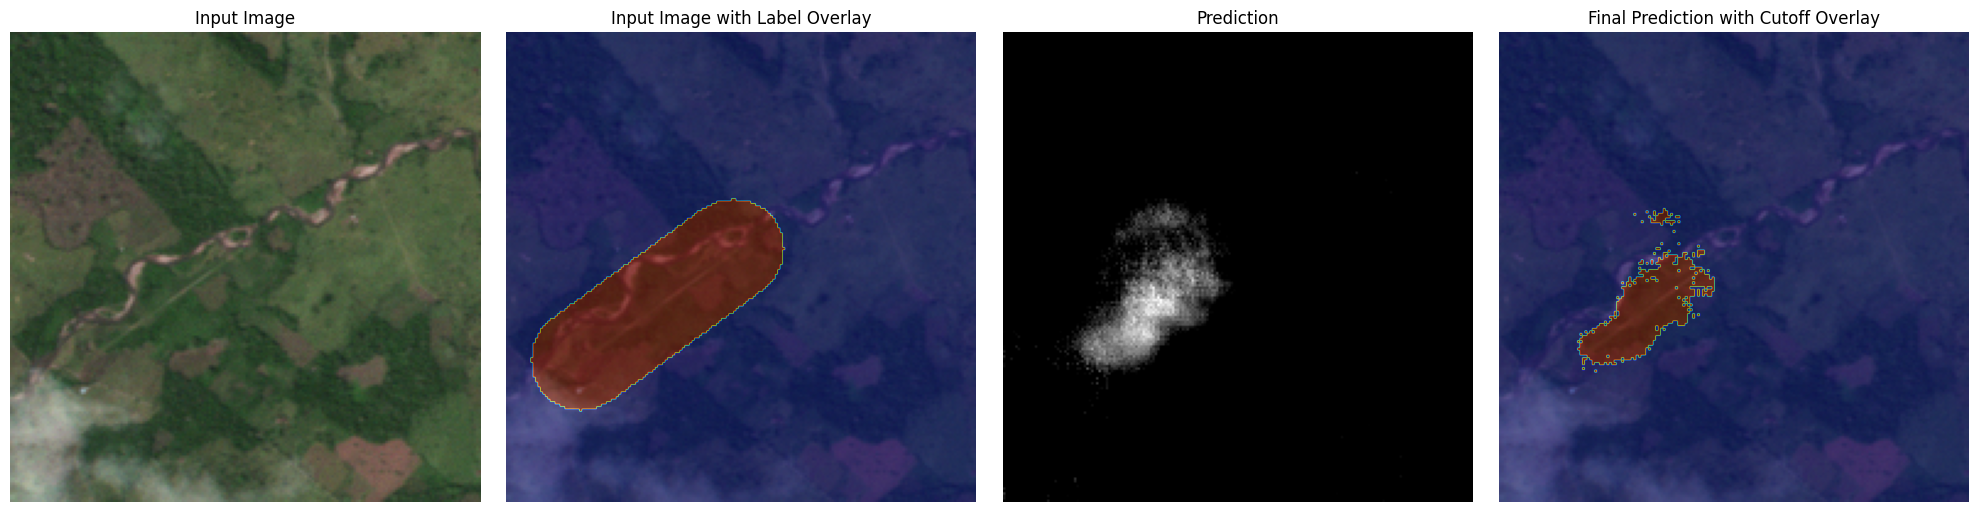

Sample 1: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


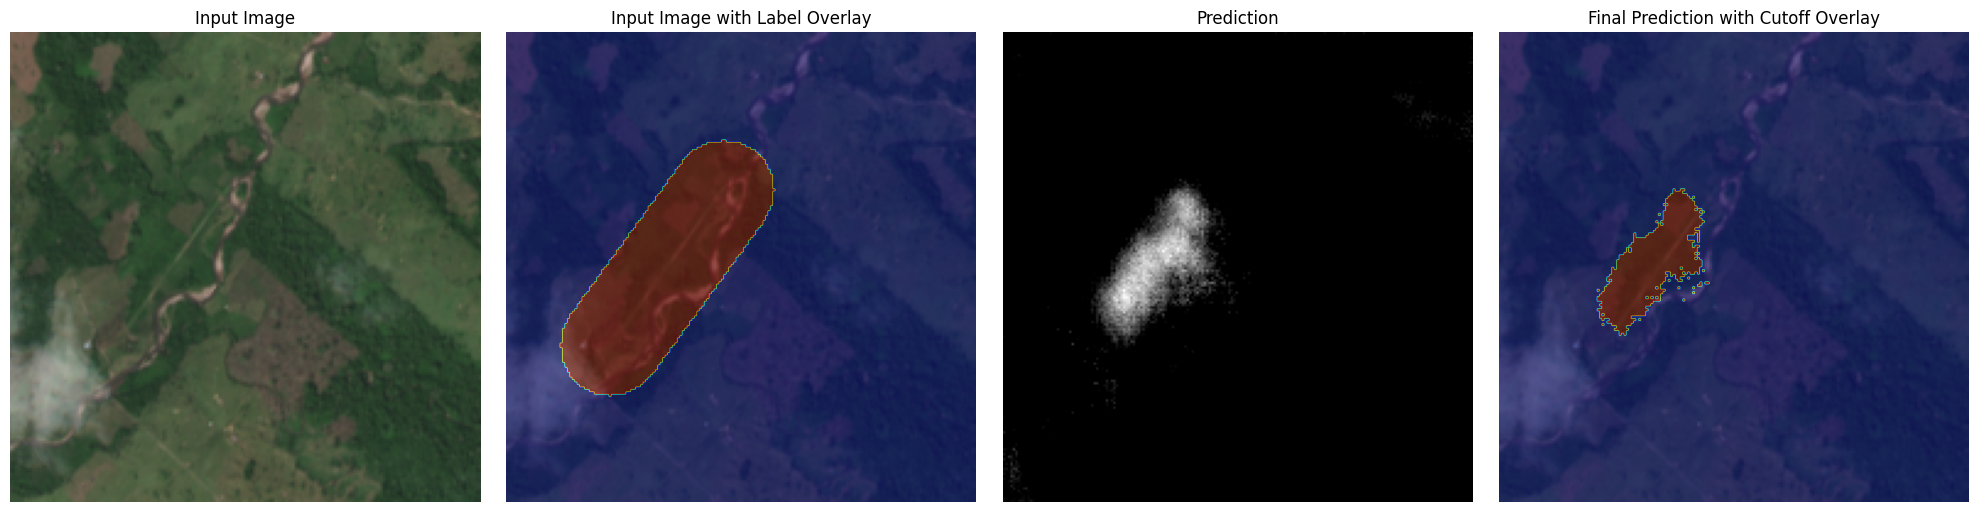

Sample 2: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


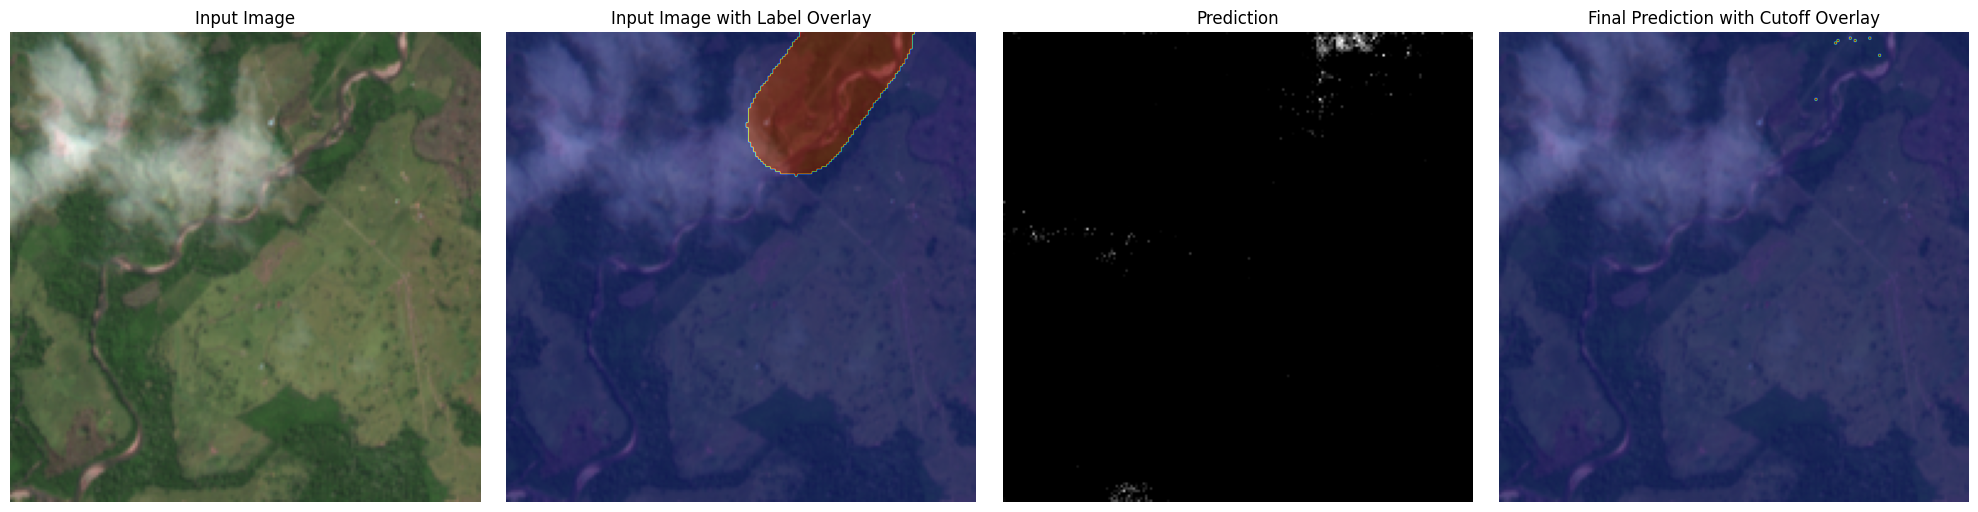

Sample 3: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


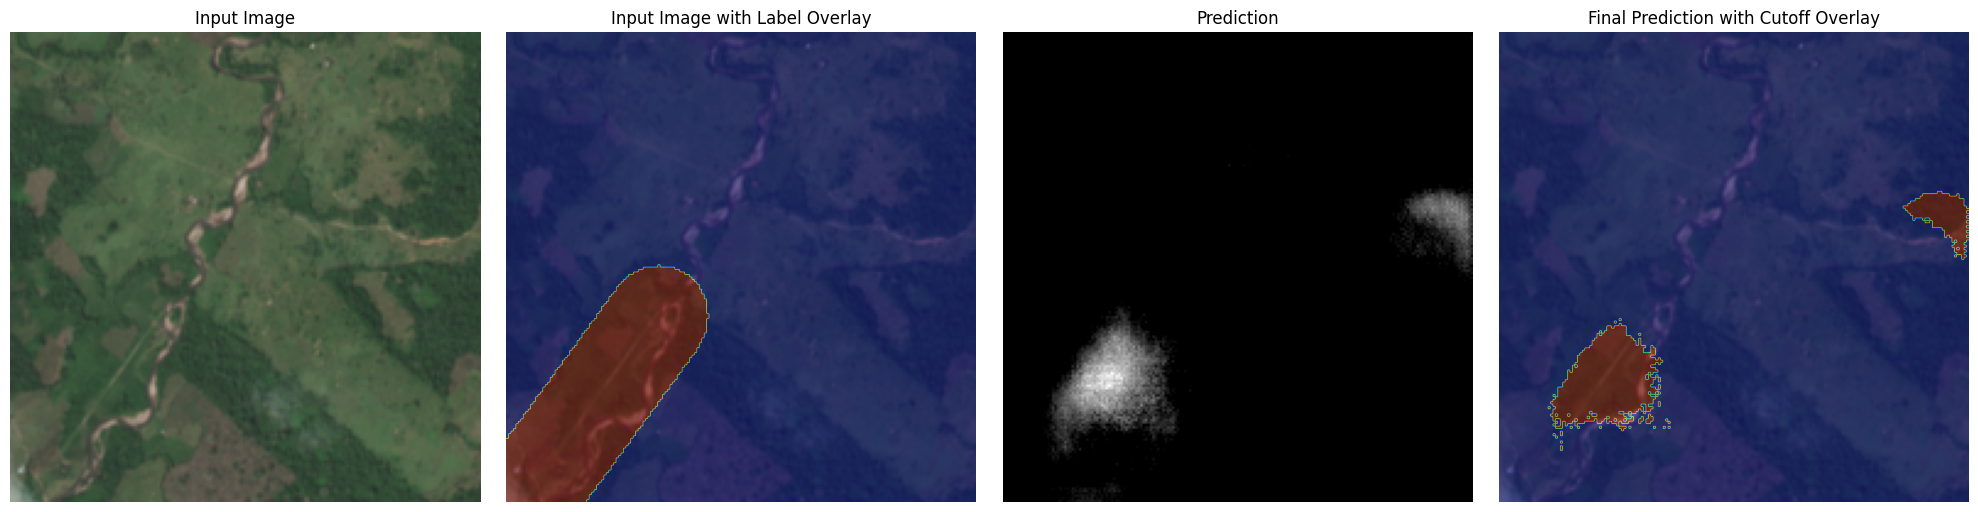

Sample 4: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


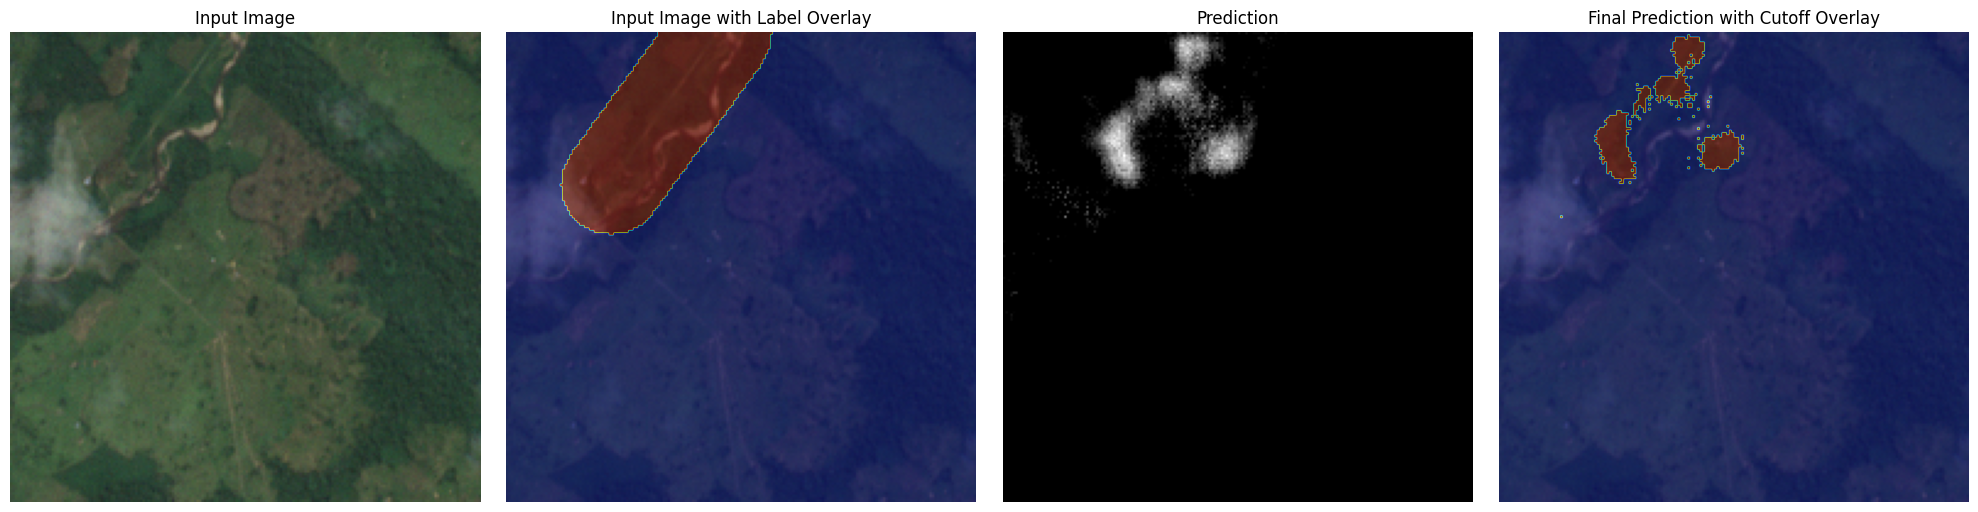

In [22]:
# Visualize predictions for a few VALIDATION samples
visualize_predictions(model, val_dataset, num_samples=5, overlay=True, cutoff_multiplier=1)

Sample 0: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


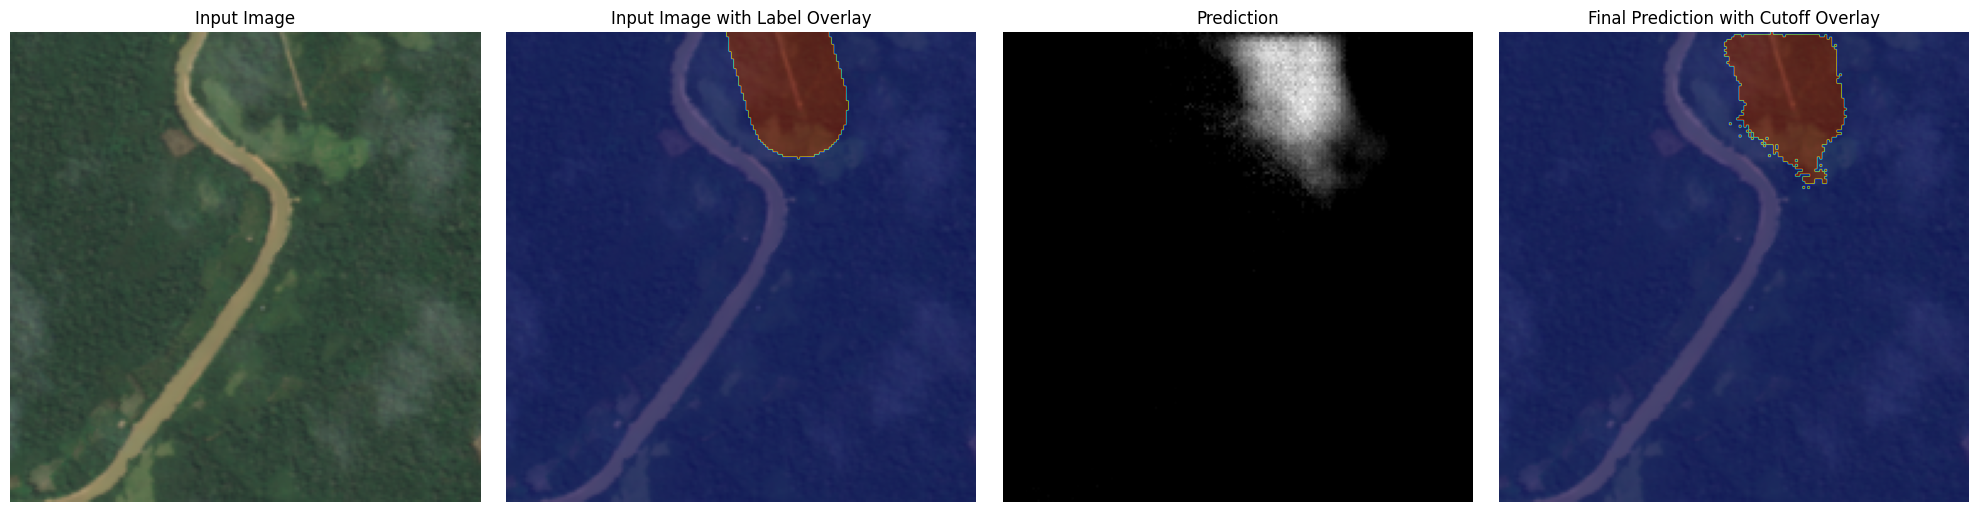

Sample 1: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


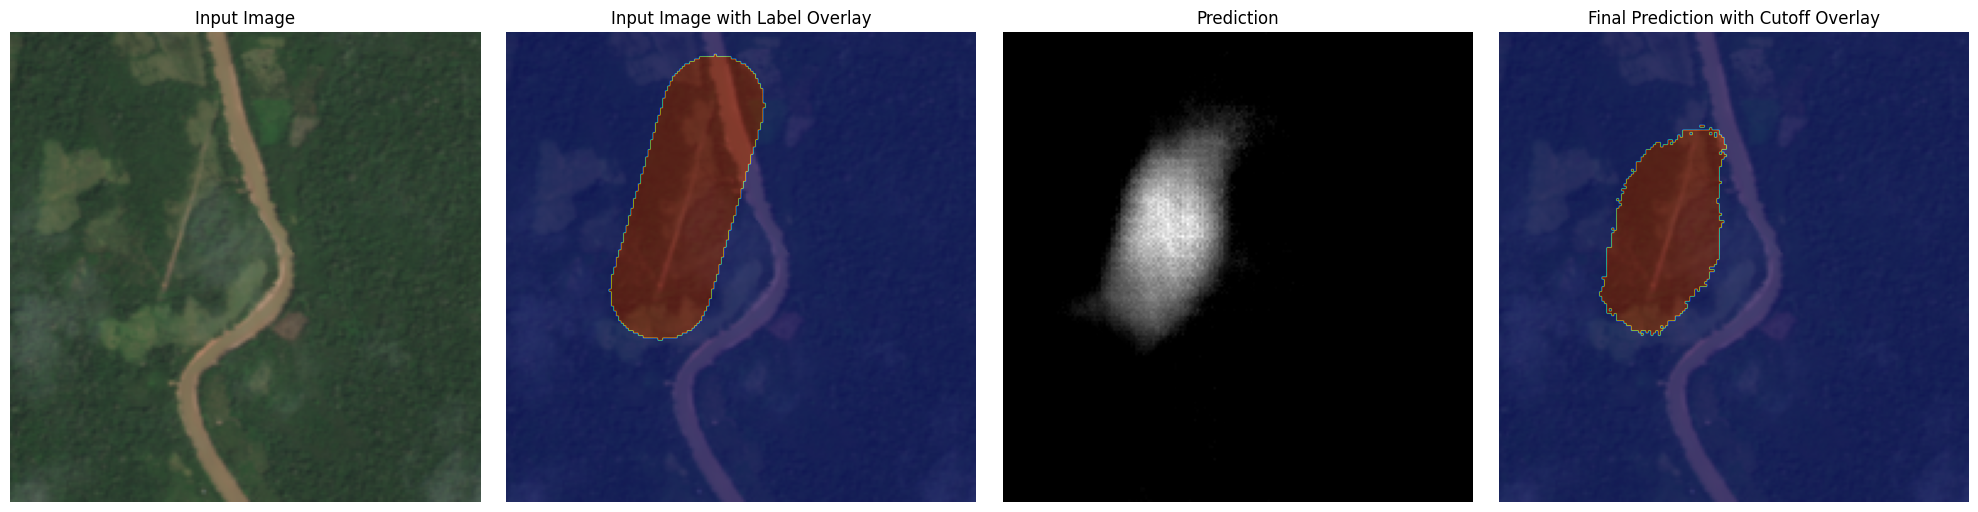

Sample 2: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


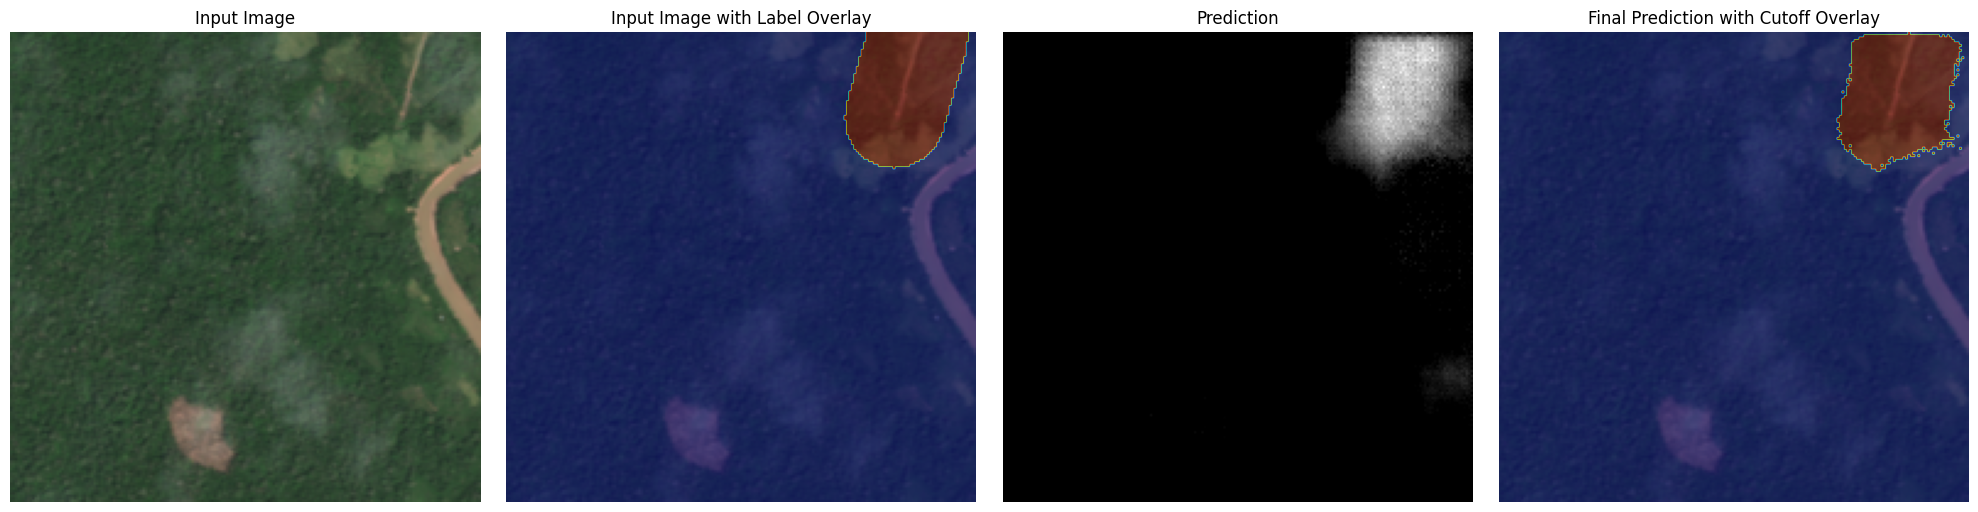

Sample 3: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


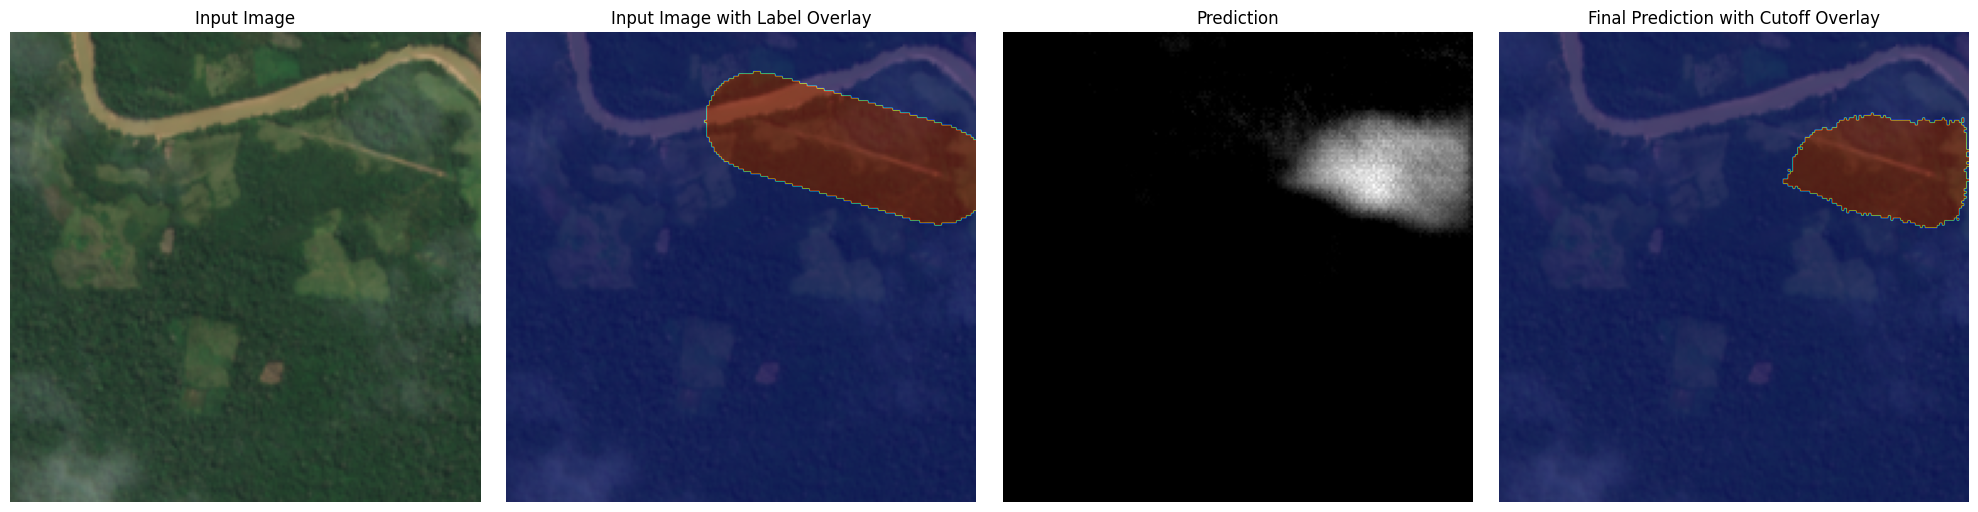

Sample 4: Image shape torch.Size([3, 192, 192]), Label shape torch.Size([192, 192])
0.0


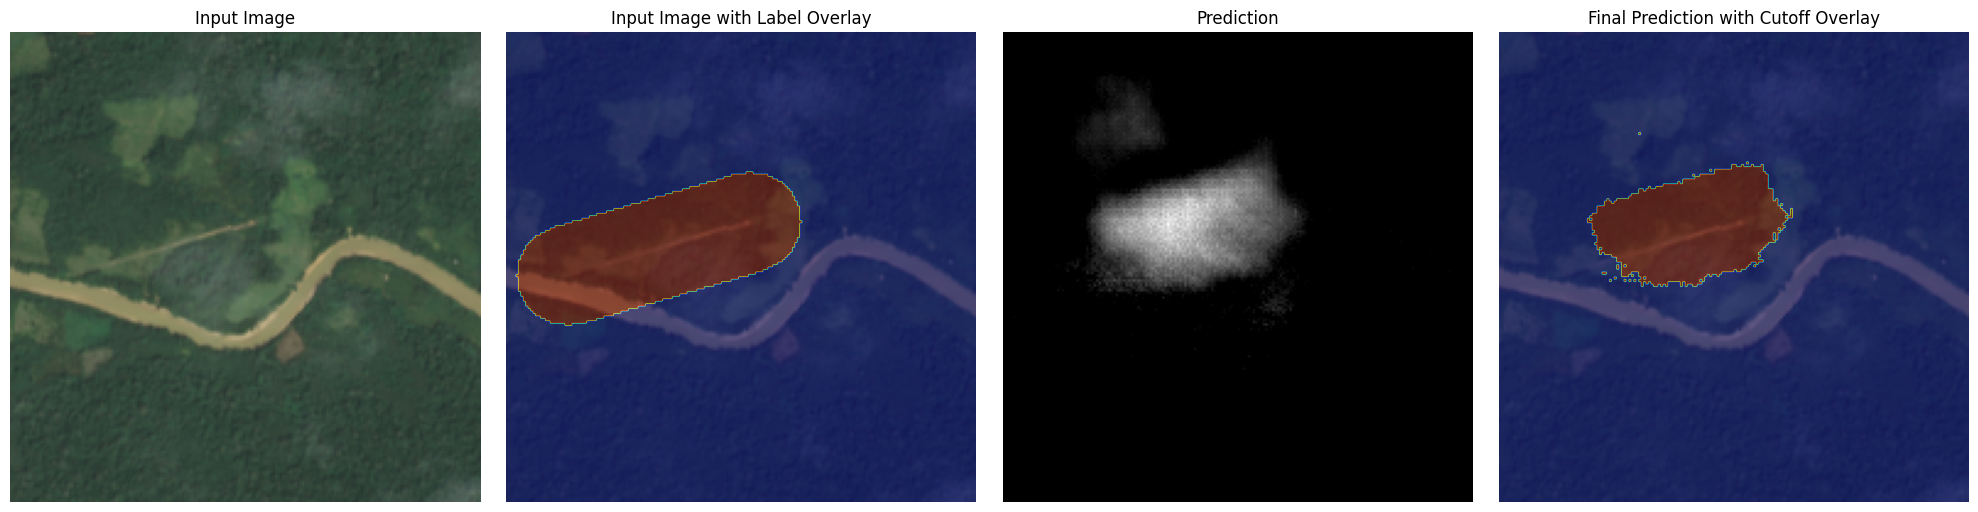

In [19]:
# Visualize predictions for a few TRAINING samples
visualize_predictions(model, train_dataset, num_samples=5, overlay=True, cutoff_multiplier=2)

In [20]:
def check_predictions_similarity(model, dataset):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(15):
            sample = dataset[i]
            input_image = sample[0].unsqueeze(0)  # Add batch dimension
            prediction = model(input_image).squeeze(0)  # Remove batch dimension
            predictions.append(prediction.numpy().squeeze(0))
    
    # Check if all predictions are the same
    first_prediction = predictions[0]
    all_same = all(np.array_equal(first_prediction, pred) for pred in predictions)
    
    if all_same:
        print("All predictions are the same.")
    else:
        print("Predictions vary across images.")

# Check predictions similarity for validation dataset
check_predictions_similarity(model, val_dataset)

Predictions vary across images.


In [21]:
def measure_variation(model, dataset, indices):
    model.eval()
    variations = []
    with torch.no_grad():
        for idx in indices:
            sample = dataset[idx]
            input_image = sample[0].unsqueeze(0)  # Add batch dimension
            prediction = model(input_image).squeeze(0)  # Remove batch dimension
            variations.append(prediction.numpy().squeeze(0))
    
    # Calculate the average variation per pixel
    variations = np.array(variations)
    mean_variation = np.mean(np.std(variations, axis=0))
    
    return mean_variation

# Measure variation for images at indices 1, 50, and 100
indices = [1, 50, 100]
average_variation = measure_variation(model, val_dataset, indices)
print(f"Average variation per pixel: {average_variation}")

Average variation per pixel: 0.13160666823387146
